# Models for Larger Dataset

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [8]:
path  =  "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/colonoscopy2/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)
data_path = path+'subset/'

In [3]:
batch_size = 32

## Preparation
Check up the labels and image files. Split into training and validation sets. 

In [6]:
filenames = os.listdir(data_path)

In [9]:
labels = pd.read_excel(path+'colonoscopy_mayo_labeled_07May.xlsx')

In [15]:
labels.columns

Index(['basefile', 'pathname', 'SourceReportName', 'Inflamm_Mayo_0',
       'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3', 'Poor_GRAPHIC',
       'Poor_Image_UNCLASSIFIED'],
      dtype='object')

Make a subset copy of the images, so the generator can run faster. 

In [34]:
labeled = set(labels.basefile)

from shutil import copyfile

for f in filenames:
    if f in labeled:
        copyfile(data_path+f, path+'subset/'+f)

In [62]:
labels.Inflamm_Mayo_3.value_counts()

False    11666
True      1150
Name: Inflamm_Mayo_3, dtype: int64

Create labels for multi-binary classification:

In [16]:
labels['split0_123'] = (~labels.Inflamm_Mayo_0).astype(int)
labels['split01_23'] = (labels.Inflamm_Mayo_2 | labels.Inflamm_Mayo_3).astype(int)
labels['split012_3'] = labels.Inflamm_Mayo_3.astype(int)

In [73]:
labels.split0_123.value_counts()

0    7214
1    5602
Name: split0_123, dtype: int64

In [74]:
labels.split01_23.value_counts()

0    9961
1    2855
Name: split01_23, dtype: int64

In [41]:
labels.split012_3.value_counts()

0    10396
1     1041
Name: split012_3, dtype: int64

In [10]:
labels['Mayo_score'] = 0
labels.loc[labels.Inflamm_Mayo_1, 'Mayo_score'] = 1
labels.loc[labels.Inflamm_Mayo_2, 'Mayo_score'] = 2
labels.loc[labels.Inflamm_Mayo_3, 'Mayo_score'] = 3

In [11]:
labels.Mayo_score.value_counts()

0    7187
1    2774
2    1705
3    1150
Name: Mayo_score, dtype: int64

In [5]:
labels = pd.read_csv(path+'train_labels.csv')

In [17]:
split = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=24)
ind = split.split(labels, groups=labels['SourceReportName'])
trn_ind, val_ind = next(ind)

trn_patients = set(labels.loc[trn_ind, 'SourceReportName'])
val_patients = set(labels.loc[val_ind, 'SourceReportName'])

In [18]:
trn_df = labels.loc[trn_ind, ]
val_df = labels.loc[val_ind, ]

In [19]:
len(trn_patients), len(val_patients)

(2077, 231)

In [20]:
val_df.split012_3.value_counts()

0    1165
1     139
Name: split012_3, dtype: int64

In [21]:
val_df.Mayo_score.value_counts()

0    741
1    277
2    147
3    139
Name: Mayo_score, dtype: int64

In [23]:
tst_df.to_csv(path+'test_labels.csv', index=False)

In [24]:
trn_df.to_csv(path+'train_labels.csv', index=False)

In [9]:
tst_df = pd.read_csv(path+'test_labels.csv')

## Data Generator

In [10]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
from keras_addon import ImageFrameGenerator

In [29]:
import keras_addon
from importlib import reload
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [37]:
train_gen = ImageFrameGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [38]:
validation_gen = ImageFrameGenerator()

In [39]:
train_itr = train_gen.flow_from_frame(data_path, trn_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size)

Found 12816 images in the directory.
Using 9161 images to generate mini-batches.


In [59]:
val_itr = validation_gen.flow_from_frame(data_path, val_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using 2271 images to generate mini-batches.


In [60]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using 1378 images to generate mini-batches.


In [53]:
X_batch, y_batch = next(train_itr)

FS_1493-2.jpg
FS_416-5.jpg
BM_col_1821-5.jpg
EW_col_1190-4.jpg
EW_col_944-4.jpg
FS_1146-2.jpg
FS_1239-4.jpg
FS_1634-2.jpg


In [54]:
y_batch

{'split012_3': array([1, 0, 0, 0, 0, 0, 0, 0]),
 'split01_23': array([1, 0, 0, 0, 0, 1, 0, 0]),
 'split0_123': array([1, 0, 0, 0, 0, 1, 0, 1])}

In [56]:
fn = '''FS_1493-2.jpg
FS_416-5.jpg
BM_col_1821-5.jpg
EW_col_1190-4.jpg
EW_col_944-4.jpg
FS_1146-2.jpg
FS_1239-4.jpg
FS_1634-2.jpg'''.split('\n')

In [60]:
trn_df.loc[trn_df['basefile'].isin(fn), ['basefile', 'split0_123', 'split01_23', 'split012_3']]

,basefile,split0_123,split01_23,split012_3
670,BM_col_1821-5.jpg,0,0,0
2615,EW_col_1190-4.jpg,0,0,0
3418,EW_col_944-4.jpg,0,0,0
4397,FS_1146-2.jpg,1,1,0
4570,FS_1239-4.jpg,0,0,0
5027,FS_1493-2.jpg,1,1,1
5337,FS_1634-2.jpg,1,0,0
8590,FS_416-5.jpg,0,0,0


In [14]:
from utils import plots

## Model Building

In [19]:
from keras.applications.inception_v3 import InceptionV3

In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(1, activation='sigmoid', name='split0_123')(x)
output2 = Dense(1, activation='sigmoid', name='split01_23')(x)
output3 = Dense(1, activation='sigmoid', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [64]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [65]:
checkpointer = ModelCheckpoint(filepath=model_path+'phase2_0511.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model.fit_generator(train_itr, steps_per_epoch=train_itr.n // batch_size, epochs=200, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, reduce_lr, earlystop], 
                                verbose=1)

Epoch 1/200
286/286 [==============================] - 457s 2s/step - loss: 1.0631 - split0_123_loss: 0.5156 - split01_23_loss: 0.3514 - split012_3_loss: 0.1961 - split0_123_acc: 0.7462 - split01_23_acc: 0.8523 - split012_3_acc: 0.9227 - val_loss: 1.3938 - val_split0_123_loss: 0.6226 - val_split01_23_loss: 0.4715 - val_split012_3_loss: 0.2997 - val_split0_123_acc: 0.7384 - val_split01_23_acc: 0.8094 - val_split012_3_acc: 0.8839
Epoch 2/200
286/286 [==============================] - 444s 2s/step - loss: 0.9114 - split0_123_loss: 0.4434 - split01_23_loss: 0.2974 - split012_3_loss: 0.1706 - split0_123_acc: 0.7975 - split01_23_acc: 0.8738 - split012_3_acc: 0.9332 - val_loss: 1.8149 - val_split0_123_loss: 0.9771 - val_split01_23_loss: 0.6006 - val_split012_3_loss: 0.2373 - val_split0_123_acc: 0.6710 - val_split01_23_acc: 0.8496 - val_split012_3_acc: 0.9411
Epoch 3/200
286/286 [==============================] - 439s 2s/step - loss: 0.8662 - split0_123_loss: 0.4284 - split01_23_loss: 0.2751 -

## Result Evaluation

In [79]:
model.load_weights(model_path+'phase2_0511_2.h5')

In [80]:
y = model.predict_generator(tst_itr, verbose=1)

44/44 [==============================] - 20s 451ms/step


In [81]:
y_pred = np.concatenate(y, axis=1)

In [63]:
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

In [64]:
y_pred.shape, y_true.shape

((1378, 3), (1378, 3))

In [27]:
from DL_utils import plot_roc

{0: 0.9108663344697963, 1: 0.9609973839110529, 2: 0.9733952183688666}

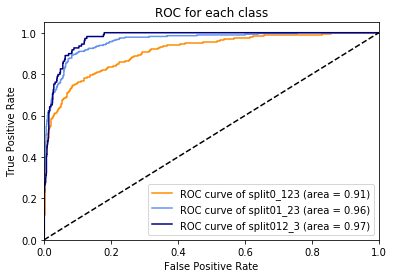

In [82]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

## Test on Video data

In [6]:
video_path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/'

In [7]:
video_labels = pd.read_excel(video_path+'UC_Images_Labels/UC_deeplearning_imageLabels.xlsx')